In [2]:
import networkx as nx
import random as ra
import matplotlib.pyplot as pltt
import numpy as np
import pandas as pd
from collections import Counter
from scipy.stats import lomax
import copy
import itertools

In [3]:
def random(graph,alpha=3,rtype='exp',max_value=10):
    expected_LI = []
    if rtype == 'exp':
        expected_LI = max_value * np.random.exponential(scale=1/2,size=(graph.number_of_nodes()))
    elif rtype == 'pareto':
        expected_LI= max_value * lomax.rvs(alpha, size=(graph.number_of_nodes()))
    elif rtype == 'uniform':
        expected_LI = max_value * np.random.sample(size=(graph.number_of_nodes()))
    return expected_LI

In [4]:
def update_iter(graph,lifetime,searched):
    lifetime = lifetime-1
    searched = searched+1
    for i in range(len(lifetime)):
        if lifetime[i]<0:
            if i in graph:
                graph.remove_node(i)        
    return lifetime,searched

In [5]:
def is_ended(lifetime):
    for i in range(len(lifetime)):
        if lifetime[i] > 0:
            return False
    return True

In [6]:
def rewire(graph,searchtime,searched):   
    for i in range(len(searchtime)):
        if i in graph:
            if searchtime[i] <= searched[i] :
                searched[i]=0
                non_neighbors=nx.non_neighbors(graph,i)
                try:
                    j=next(non_neighbors)
                    while j not in graph:
                        j=next(non_neighbors)
                    graph.add_edge(i,j) 
                except StopIteration:
                    continue
    return searched            

In [7]:
def calculate_T(graph,T):
    for node , degree in graph.degree():
        if degree != 0:
            T[node] = T[node]+1
    return T

In [8]:
def get_ET(graph,T):
    ET= np.zeros((graph.number_of_nodes()))
    countdegree = np.zeros((graph.number_of_nodes()))
    for i in range(len(graph.nodes())):
        ET[i]=0
    for i in range(len(graph.nodes())):
        countdegree[graph.degree[i]] = countdegree[graph.degree[i]] +1
        ET[graph.degree[i]] =  ET[graph.degree[i]] + T[i]
    index=[]
    for i in range(len(graph.nodes())):
        index.append("degree"+str(i))
        if countdegree[i] != 0:
            ET[i] =  ET[i]/countdegree[i]
   
    return ET

In [9]:
def get_T_k(iteration,active,lifetype,n,p,maxlife,maxEs,alpha=3):
    Elf={}
    Es={}
    ET={}
    G1 = nx.erdos_renyi_graph(n,p)
    for i in range(iteration):
        G=copy.deepcopy(G1)
        lifetime = random(G,alpha = alpha,rtype=lifetype,max_value=maxlife)
        searchtime = random(G,rtype='uniform',max_value=maxEs)
        Elf['iter'+str(i)]=np.mean(lifetime)
        Es['iter'+str(i)]=np.mean(searchtime)
        s = np.zeros((G.number_of_nodes()))
        T = np.zeros((G.number_of_nodes()))
        while not is_ended(lifetime):
            T = calculate_T(G,T)
            if active:
                s = rewire(G,searchtime,s)
            lifetime,s = update_iter(G,lifetime,s)    
        ET['iter'+str(i)]=get_ET(G1,T)
    
    return {"Elf":Elf , "Es":Es , "ET":ET}

In [10]:
def get_T(iteration,active,lifetype,n,p,maxlife,maxEs,alpha=3):
    Elf={}
    Es={}
    ET={}
    G1 = nx.erdos_renyi_graph(n,p)
    for i in range(iteration):
        G=copy.deepcopy(G1)
        lifetime = random(G,alpha = alpha,rtype=lifetype,max_value=maxlife)
        searchtime = random(G,rtype='uniform',max_value=maxEs)
        Elf['iter'+str(i)]=np.mean(lifetime)
        Es['iter'+str(i)]=np.mean(searchtime)
        s = np.zeros((G.number_of_nodes()))
        T = np.zeros((G.number_of_nodes()))
        while not is_ended(lifetime):
            T = calculate_T(G,T)
            if active:
                s = rewire(G,searchtime,s)
            lifetime,s = update_iter(G,lifetime,s)
        ET['iter'+str(i)]=T
    return {"Elf":Elf , "Es":Es , "ET":ET}

In [10]:
this = get_T(4,True,'exp',50,0.5,10000,1000,3)
df=pd.DataFrame(this)

In [11]:
df['ET']

iter0    [295.0, 12447.0, 119.0, 4504.0, 2433.0, 1425.0...
iter1    [1418.0, 858.0, 2881.0, 6771.0, 5669.0, 839.0,...
iter2    [4210.0, 12661.0, 1439.0, 14060.0, 2149.0, 506...
iter3    [938.0, 7925.0, 12311.0, 7124.0, 1795.0, 9632....
Name: ET, dtype: object

In [12]:
df['phi']=df['Elf']/pd.DataFrame(df['ET'].tolist(),index=df.index).mean(axis=1)
df

,Elf,Es,ET,phi
iter0,4193.777459,529.904408,"[295.0, 12447.0, 119.0, 4504.0, 2433.0, 1425.0...",1.044377
iter1,4790.076842,475.912192,"[1418.0, 858.0, 2881.0, 6771.0, 5669.0, 839.0,...",1.036082
iter2,4631.758959,466.976894,"[4210.0, 12661.0, 1439.0, 14060.0, 2149.0, 506...",1.016811
iter3,4502.412028,479.508226,"[938.0, 7925.0, 12311.0, 7124.0, 1795.0, 9632....",1.009356


In [11]:
def get_tdiffp(iteration,n,gap,Esearch,maxlife):
    result={}

    for i in range(int(1/gap)):
        this = get_T_k(iteration,False,'exp',n,i*gap,maxlife,Esearch)
        df=pd.DataFrame(this)
        df=pd.DataFrame(pd.DataFrame(df['ET'].to_list()).replace(0,np.nan).mean(skipna=True))
        result[str(n*round(i*gap,2))]={}
        result[str(n*round(i*gap,2))]["exp_inactive"]=df[0]
        this = get_T_k(iteration,True,'exp',n,i*gap,maxlife,Esearch)
        df=pd.DataFrame(this)
        df=pd.DataFrame(pd.DataFrame(df['ET'].to_list()).replace(0,np.nan).mean(skipna=True))
        result[str(n*round(i*gap,2))]["exp_active"]=df[0]
        this = get_T_k(iteration,False,'pareto',n,i*gap,maxlife,Esearch)
        df=pd.DataFrame(this)
        df=pd.DataFrame(pd.DataFrame(df['ET'].to_list()).replace(0,np.nan).mean(skipna=True))
        result[str(n*round(i*gap,2))]["pareto_inactive"]=df[0]
        this = get_T_k(iteration,True,'pareto',n,i*gap,maxlife,Esearch)
        df=pd.DataFrame(this)
        df=pd.DataFrame(pd.DataFrame(df['ET'].to_list()).replace(0,np.nan).mean(skipna=True))
        result[str(n*round(i*gap,2))]["pareto_active"]=df[0]
    result = pd.DataFrame(result)
    result
    return result

In [16]:
def get_tdiffs(iteration,n,p,gap,maxlife):
    result={}

    for i in range(1,int(0.1/gap)):
        this = get_T(iteration,True,'exp',n,p,maxlife,maxlife*(i*gap),3)
        df=pd.DataFrame(this)
        df=np.array(df['ET'].tolist(),dtype=object).mean().mean()
        result[str(round(maxlife*i*gap,2))]={}
        result[str(round(maxlife*i*gap,2))]["exp_active"]=df
        this = get_T(iteration,True,'pareto',n,p,maxlife,maxlife*(i*gap),3)
        df=pd.DataFrame(this)
        df=np.array(df['ET'].tolist(),dtype=object).mean().mean()
        result[str(round(maxlife*i*gap,2))]["pareto_active"]=df
    return pd.DataFrame(result)

In [13]:
def get_phidiffs(iteration,n,p,gap,maxlife):
    result={}
    for i in range(1,int(0.1/gap)):
        result[str(round(50*i*gap,2))]={}
        this = get_T(iteration,True,'exp',n,p,maxlife,maxlife*(i*gap),3)
        df=pd.DataFrame(this)
        df['ET']=pd.DataFrame(df['ET'].tolist(),index=df.index).mean(axis=1)
        df['phi']=df['Elf']/df['ET']
        result[str(round(50*i*gap,2))]["exp_active"]= df['phi']
        this = get_T(iteration,True,'exp',n,p,maxlife,maxlife*(i*gap),3)
        df=pd.DataFrame(this)
        df['ET']=pd.DataFrame(df['ET'].tolist(),index=df.index).mean(axis=1)
        df['phi']=df['Elf']/df['ET']
        result[str(round(50*i*gap,2))]["pareto_active"]= df['phi']
    return pd.DataFrame(result)

# E[T] and k

In [16]:
res1 = get_tdiffp(500,50,0.05,10,1000)

In [17]:
df = pd.DataFrame()
df['exp_inactive']=pd.DataFrame(pd.DataFrame(res1.iloc[0].tolist()).mean(axis=0,skipna=True))
df['exp_active']=pd.DataFrame(pd.DataFrame(res1.iloc[1].tolist()).mean(axis=0,skipna=True))
df['pareto_inactive']=pd.DataFrame(pd.DataFrame(res1.iloc[2].tolist()).mean(axis=0,skipna=True))
df['pareto_active']=pd.DataFrame(pd.DataFrame(res1.iloc[3].tolist()).mean(axis=0,skipna=True))

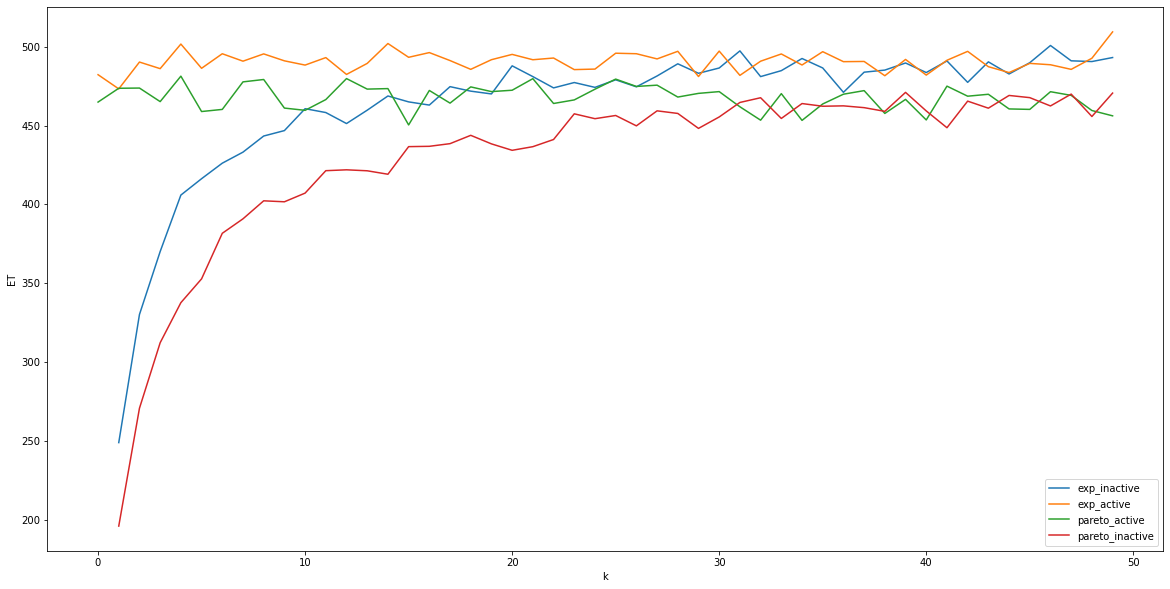

In [18]:
fig = pltt.figure(figsize=(20,10))
pltt.plot(df['exp_inactive'],label='exp_inactive')
pltt.plot(df['exp_active'],label='exp_active')
pltt.plot(df['pareto_active'],label='pareto_active')
pltt.plot(df['pareto_inactive'],label='pareto_inactive')
pltt.legend(loc='best')
pltt.xlabel('k')
pltt.ylabel('ET')
pltt.show()

# E[T] and E[s]

In [18]:
res1 = get_tdiffs(500,70,0.5,0.01,1000)

Text(0, 0.5, 'ET')

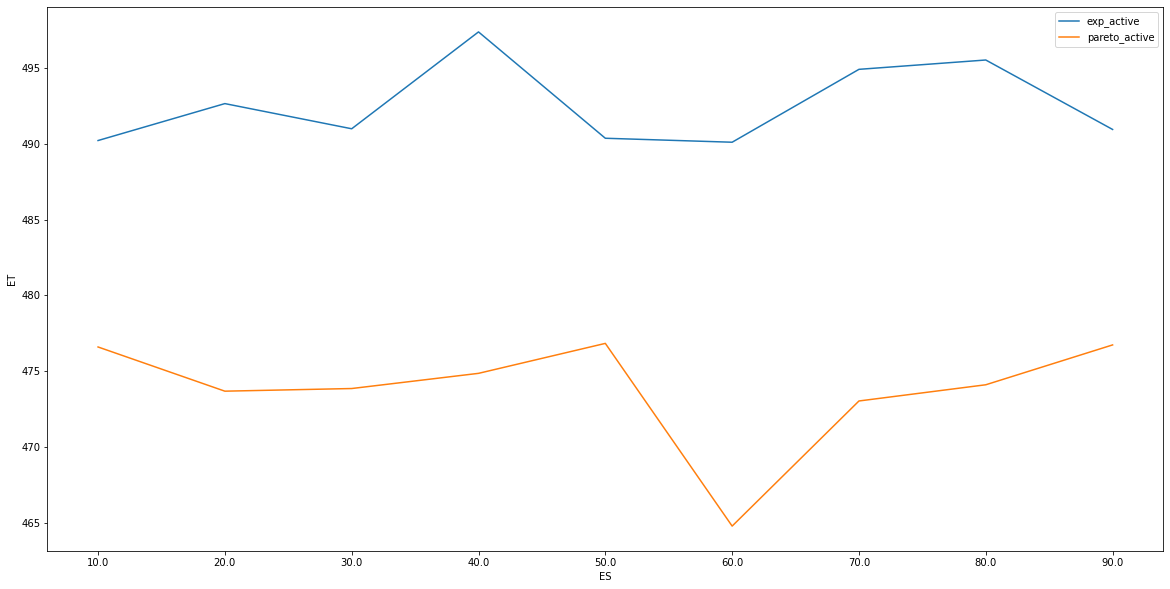

In [19]:
res1.T.plot(figsize=(20,10))
pltt.legend(loc='best')
pltt.xlabel('ES')
pltt.ylabel('ET')

# phi E[s]

In [20]:
res1 = get_phidiffs(500,70,0.5,0.01,1000)

In [21]:
df = pd.DataFrame()
df['exp_active']=pd.DataFrame(pd.DataFrame(res1.iloc[0].tolist(),index=res1.columns).mean(axis=1))
df['pareto_active']=pd.DataFrame(pd.DataFrame(res1.iloc[1].tolist(),index=res1.columns).mean(axis=1))

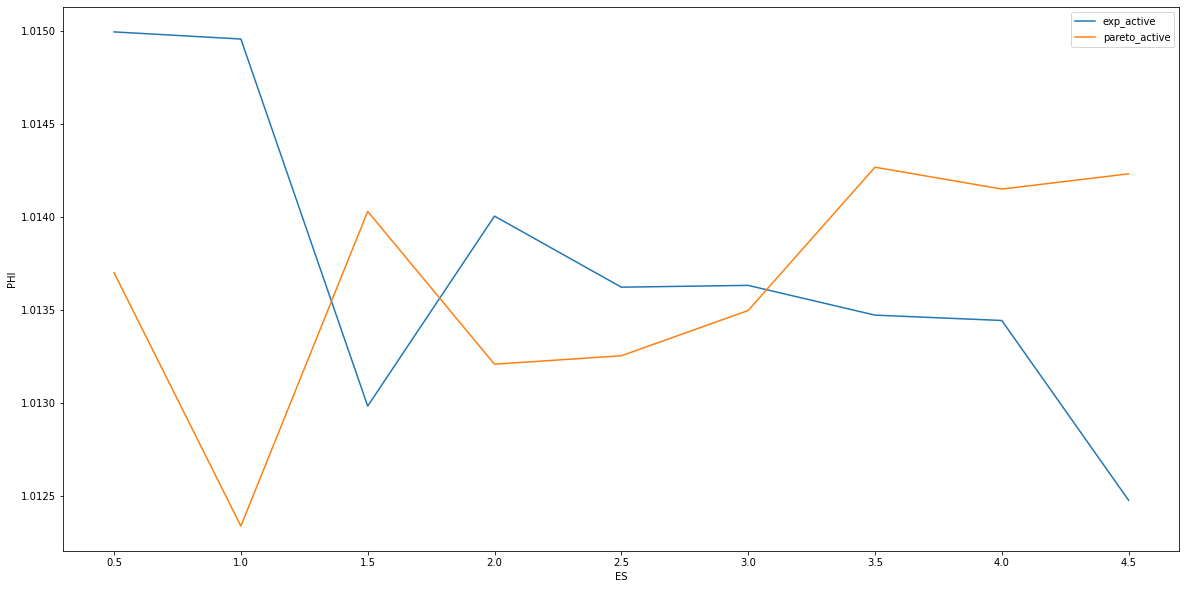

In [22]:
fig = pltt.figure(figsize=(20,10))
pltt.plot(df['exp_active'],label='exp_active')
pltt.plot(df['pareto_active'],label='pareto_active')
pltt.legend(loc='best')
pltt.xlabel('ES')
pltt.ylabel('PHI')
pltt.show()

# alpha on E[t] and phi

In [ ]:
result={}
iteration=500
n=50
p=0.5
maxlife=1000
for i in range(1,10):
    this = get_T(iteration,False,'pareto',n,p,maxlife,10,i)
    df=pd.DataFrame(this)
    df['ET']=pd.DataFrame(df['ET'].tolist(),index=df.index).mean(axis=1)
    df['phi']=df['Elf']/df['ET'] 
    result[str(i)]={}
    result[str(i)]["pareto_inactive"]= df[['phi','ET']]
    this = get_T(iteration,True,'pareto',n,p,maxlife,10,i)
    df=pd.DataFrame(this)
    df['ET']=pd.DataFrame(df['ET'].tolist(),index=df.index).mean(axis=1)
    df['phi']=df['Elf']/df['ET']
    result[str(i)]["pareto_active"]= df[['phi','ET']]
result = pd.DataFrame(result)

In [ ]:
res1 = result.applymap(lambda x:x['ET'])

In [ ]:
res2=result.applymap(lambda x:x['phi'])

In [ ]:
df = pd.DataFrame()
df['exp_active']=pd.DataFrame(pd.DataFrame(res1.iloc[0].tolist(),index=res1.columns).mean(axis=1))
df['pareto_active']=pd.DataFrame(pd.DataFrame(res1.iloc[1].tolist(),index=res1.columns).mean(axis=1))

In [ ]:
fig = pltt.figure(figsize=(20,10))
pltt.plot(df['exp_active'],label='exp_active')
pltt.plot(df['pareto_active'],label='pareto_active')
pltt.legend(loc='best')
pltt.xlabel('alpha')
pltt.ylabel('ET')
pltt.show()

In [ ]:
df = pd.DataFrame()
df['exp_active']=pd.DataFrame(pd.DataFrame(res2.iloc[0].tolist(),index=res1.columns).mean(axis=1))
df['pareto_active']=pd.DataFrame(pd.DataFrame(res2.iloc[1].tolist(),index=res1.columns).mean(axis=1))

In [ ]:
fig = pltt.figure(figsize=(20,10))
pltt.plot(df['exp_active'],label='exp_active')
pltt.plot(df['pareto_active'],label='pareto_active')
pltt.legend(loc='best')
pltt.xlabel('Alpha')
pltt.ylabel('Phi')
pltt.show()